# Keras VGG16 Feature Extraction #


#### import necessary packages ####

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import time
import os

####  Define the Feature Extraction Function ####

In [15]:
def extract_features(model, folder_path):
    # Get a list of all image files in the folder
    img_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Use list comprehension to process images and extract features
    features = []
    for img_path in img_paths:
        try:
            img = image.load_img(img_path, target_size=model.input_shape[1:3])
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            feature = model.predict(img_array)
            features.append(feature)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

    # Stack the extracted features into a single NumPy array
    features = np.vstack(features)

    return features


#### Load Pre-trained VGG16 Model and Create Feature Extraction Model ####

In [16]:
# Load the pre-trained VGG16 model with top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))  # Adjust input_shape accordingly

# Create a new model that includes only the convolutional base of VGG16
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)


#### Specify Folder Paths ####

In [17]:
# Specify folder paths for ASD and non-ASD child face image sets
asd_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD'
non_asd_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD'

#### Extract Features for ASD Child Faces ####

In [18]:
# Extract features for ASD child faces
start_time = time.time()
asd_features = extract_features(model, asd_folder_path)

end_time = time.time()
elapsed_time = end_time - start_time  # Calculate elapsed time in seconds

print("Extract Features for ASD Child Faces, time:", elapsed_time, "seconds")

1/1 [==============================] - 0s 156ms/step
Extract Features for ASD Child Faces, time: 174.13990831375122 seconds


#### Extract Features for Non-ASD Child Faces ####

In [19]:
# Extract features for non-ASD child faces
start_time = time.time()
non_asd_features = extract_features(model, non_asd_folder_path)

end_time = time.time()
elapsed_time = end_time - start_time  # Calculate elapsed time in seconds

print("Extract Features for Non-ASD Child Faces, time:", elapsed_time, "seconds")

1/1 [==============================] - 0s 152ms/step
Error processing image /Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD/child-1617.png: cannot identify image file <_io.BytesIO object at 0x158190d60>
1/1 [==============================] - 0s 182ms/step
Error processing image /Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD/additional1178.png: cannot identify image file <_io.BytesIO object at 0x17e6bb810>
1/1 [==============================] - 0s 164ms/step
Extract Features for Non-ASD Child Faces, time: 1576.749587059021 seconds


#### Save Extracted Features ####

In [9]:
# Save the extracted features for later use in training
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/asd_features.npy', asd_features)
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/non_asd_features.npy', non_asd_features)


# Model Training VGG16 #

#### import necessary packages ####

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import load_model

#### Load the extracted features for ASD and non-ASD child faces ####

In [3]:
asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/asd_features.npy')
non_asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/non_asd_features.npy')

#### Assign labels (1 for ASD, 0 for non-ASD) ####

In [4]:
asd_labels = np.ones(asd_features.shape[0])
non_asd_labels = np.zeros(non_asd_features.shape[0])

#### Combine features and labels ####

In [5]:
X = np.vstack([asd_features, non_asd_features])
y = np.concatenate([asd_labels, non_asd_labels])

#### Shuffle the data ####

In [6]:
X, y = shuffle(X, y, random_state=42)

#### Split the data into training and testing sets (70% training, 30% testing) ####

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Model definition ####

In [8]:
model = Sequential()
model.add(Flatten(input_shape=(14, 14, 512)))  # Adjust input shape to match the flattened features
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Model training ####

In [9]:
start_time = time.time()

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

end_time = time.time()
elapsed_time = end_time - start_time  # Calculate elapsed time in seconds

print("Model training time:", elapsed_time, "seconds")

Epoch 1/100


2024-03-09 16:16:20.469916: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


172/172 [==============================] - 16s 92ms/step - loss: 4.5285 - accuracy: 0.8660 - val_loss: 0.2865 - val_accuracy: 0.8932
Epoch 2/100
172/172 [==============================] - 15s 86ms/step - loss: 0.2546 - accuracy: 0.9026 - val_loss: 0.2723 - val_accuracy: 0.8997
Epoch 3/100
172/172 [==============================] - 15s 85ms/step - loss: 0.2021 - accuracy: 0.9149 - val_loss: 0.2586 - val_accuracy: 0.9026
Epoch 4/100
172/172 [==============================] - 15s 85ms/step - loss: 0.1720 - accuracy: 0.9233 - val_loss: 0.2681 - val_accuracy: 0.9150
Epoch 5/100
172/172 [==============================] - 15s 85ms/step - loss: 0.1333 - accuracy: 0.9328 - val_loss: 0.4133 - val_accuracy: 0.8990
Epoch 6/100
172/172 [==============================] - 15s 86ms/step - loss: 0.1267 - accuracy: 0.9380 - val_loss: 0.3504 - val_accuracy: 0.9004
Epoch 7/100
172/172 [==============================] - 16s 90ms/step - loss: 0.1225 - accuracy: 0.9366 - val_loss: 0.3755 - val_accuracy: 0.90

 #### Save the trained model to a file named 'VGG16Model.h5' ####

In [10]:
model.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5')

#### Model evaluation ####

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

93/93 [==============================] - 2s 23ms/step - loss: 1.1838 - accuracy: 0.9220
Test Accuracy: 0.9220074415206909


#### Predictions ####

In [12]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype('int32')

93/93 [==============================] - 3s 23ms/step


#### Classification report ####

In [13]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      2604
         1.0       0.70      0.58      0.63       345

    accuracy                           0.92      2949
   macro avg       0.82      0.77      0.80      2949
weighted avg       0.92      0.92      0.92      2949


#### Confusion matrix ####

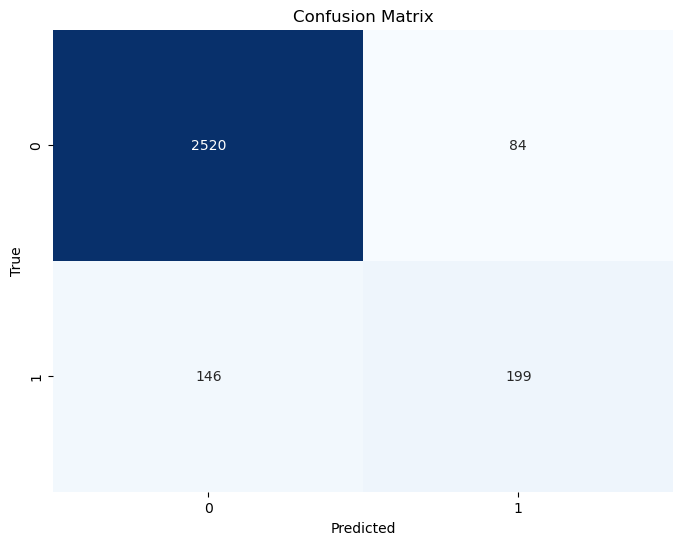

In [14]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Plot training history ####

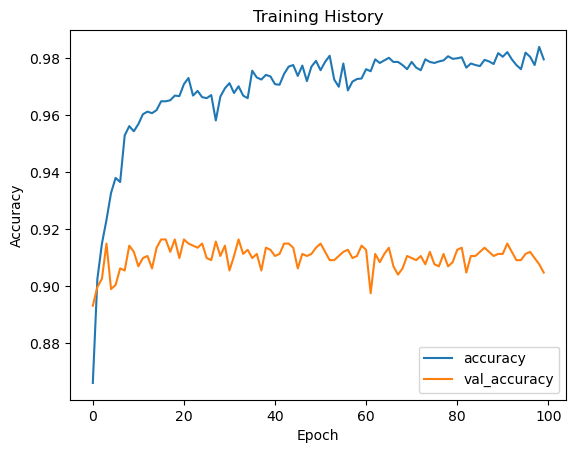

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History')
plt.show()

# Keras VGG16 Prediction #

#### Importing Libraries ####

In [1]:
import cv2
import os
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, load_model


#### Defining Paths and target size ####

In [2]:
# Define paths
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0486.jpg'  # Replace with your image path
# input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/test.jpeg'  # Replace with your image path
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
target_size = (224, 224)

#### Load Pre-trained VGG16 Model and Create a New Model ####

In [3]:
# Load the pre-trained VGG16 model with top layers included
base_model = VGG16(weights='imagenet', include_top=True)

# Create a new model that takes the input of VGG16 and outputs the desired layer
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)


#### Process Input Image and Extract Features ####

In [4]:
# Process the input image
img = cv2.imread(input_image_path)
img = cv2.resize(img, target_size)
img = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))

# Extract features using the full VGG16 model
features = model.predict(img)  # Use the new model
# Use base_model directly for feature extraction
# features = base_model.predict(img)


2024-03-17 19:27:30.984940: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 279ms/step


#### Reshape Features and Load Trained Model ####


In [5]:
# Reshape features to match the expected input shape of trained_model
features_reshaped = np.reshape(features, (features.shape[0], 14, 14, 512))  # Reshape to (None, 14, 14, 512)

# Load the trained model
trained_model = load_model(model_path)

#### Predict ASD Probability and Interpret the Prediction ####

In [6]:
# Predict ASD probability using the trained model and extracted features
prediction = trained_model.predict(features_reshaped)[0][0]  # Access the first element for ASD probability
print("prediction: ", prediction)
print("prediction: {:.5f}".format(prediction))

# Interpret the prediction
rounded_prediction = round(prediction, 2)
print(f"Predicted probability: {rounded_prediction:.2f}")

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")


1/1 [==============================] - 0s 137ms/step
prediction:  1.0
prediction: 1.00000
Predicted probability: 1.00
Predicted ASD with probability: 1.00


# XAI LIME #

### Import necessary libraries ###

In [72]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from skimage.segmentation import mark_boundaries
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from PIL import Image
from pathlib import Path
from IPython.display import display
from lime.lime_image import LimeImageExplainer

### Provide the path to the image file ###

In [73]:
image_path = "/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0579.jpg"

### Provide the model path ###

In [74]:
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
target_size = (224, 224)

### Load the pre-trained VGG16 model with top layers included ###

In [75]:
base_model = VGG16(weights='imagenet', include_top=True)

### Take the output of the base model up to the last convolutional layer ###

In [76]:
x = base_model.get_layer('block5_pool').output

### Add a new dense layer for output ###

In [77]:
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

### Create a new model that takes the input of VGG16 and outputs the desired layer ###

In [78]:
model = Model(inputs=base_model.input, outputs=predictions)

### Process the input image ###

In [79]:
img = np.array(Image.open(image_path).resize(target_size))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR
img = np.expand_dims(img, axis=0)  # Add a batch dimension
img = preprocess_input(img)  # Preprocess the image

### Preprocess the image for the explainer by dividing pixel values by 255 ###

In [80]:
img_scaled = img / 255.0

###  Predict ASD probability using the full VGG16 model ###

1/1 [==============================] - 0s 170ms/step
Predicted probability: 0.65
Predicted ASD with probability: 0.65


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


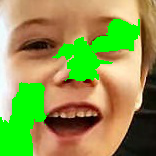

Generate time to XAI: 1455.206916809082 seconds


In [81]:
prediction = model.predict(img)[0][0]  # Access the first element for ASD probability

rounded_prediction = round(prediction, 2)
print(f"Predicted probability: {rounded_prediction:.2f}")

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
    
    start_time = time.time()
    explainer = LimeImageExplainer()

    # Call the function to generate and visualize explanation
    explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0, num_samples=10000, random_seed=42)

    # Visualize the explanation using matplotlib
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    # Resize the explanation mask to match the original image dimensions
    mask = cv2.resize(mask, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)

    # Convert the mask to the original image mode
    original_image = Image.open(image_path)
    original_width, original_height = original_image.size
    original_mode = original_image.mode

    # Overlay the explanation mask on the original image
    mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    original_image = np.array(original_image)
    original_image[mask > 0.5] = (0, 255, 0)

    # Display the original image with the explanation mask
    display(Image.fromarray(original_image))
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate elapsed time in seconds
    
    print("Generate time to XAI:", elapsed_time, "seconds")
else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")

# XAI Grad CAM #

### Import necessary libraries ###

In [82]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, load_model
import tensorflow as tf

### Define Grad-CAM function ###

In [83]:
def generate_grad_cam(model, img_array, layer_name):
    # Create a model that maps the input image to the desired layer's output
    grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))

    # Compute the gradient of the predicted class with respect to the output feature map of the given layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        predicted_class_output = preds[:, 0]  # ASD class index assuming ASD class is the first one

    grads = tape.gradient(predicted_class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    # Compute the heatmap
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

### Define paths ###

In [84]:
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0649.jpg'  # Replace with your image path
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
target_size = (224, 224)

### Load the pre-trained VGG16 model with top layers included ###

In [85]:
base_model = VGG16(weights='imagenet', include_top=True)

### Create a new model that takes the input of VGG16 and outputs the desired layer ###

In [86]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)

### Process the input image ###

In [87]:
img_original = cv2.imread(input_image_path)
img_original = cv2.resize(img_original, target_size)
img_for_model = preprocess_input(np.expand_dims(img_original, axis=0))

### Extract features using the full VGG16 model ###

In [88]:
features = model.predict(img_for_model)  # Use the new model

1/1 [==============================] - 0s 230ms/step


### Reshape features to match the expected input shape of trained_model ###

In [89]:
features_reshaped = np.reshape(features, (features.shape[0], 14, 14, 512))

### Load the trained model ###

In [90]:
trained_model = load_model(model_path)

### Predict ASD probability using the trained model and extracted features ###

In [91]:
prediction = trained_model.predict(features_reshaped)[0][0]   # Access the first element for ASD probability
print("prediction: ", prediction)
print("prediction: {:.5f}".format(prediction))

1/1 [==============================] - 0s 84ms/step
prediction:  1.0
prediction: 1.00000


### Interpret the prediction and if ASD then show grad cam ###

Prediction: 1.00000
Predicted ASD with probability: 1.00


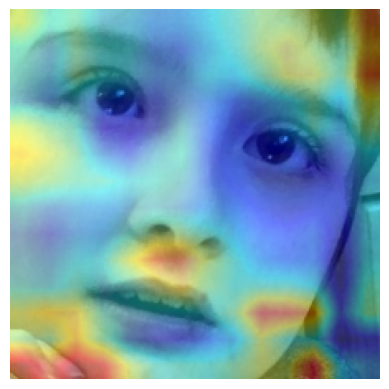

In [92]:
rounded_prediction = round(prediction, 2)
print("Prediction: {:.5f}".format(prediction))

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

    # Visualize the Grad-CAM heatmap
    heatmap = generate_grad_cam(model, img_for_model, 'block5_conv3')

    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))

    # Apply colormap for better visualization
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)

    # Display the superimposed image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")


2024-02-20 21:43:53.232768: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 282ms/step
Predicted probability: 0.72
Predicted ASD with probability: 0.72


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


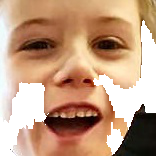

In [1]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from skimage.segmentation import mark_boundaries
# from keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# from PIL import Image
# from pathlib import Path
# from IPython.display import display
# from lime.lime_image import LimeImageExplainer
# 
# def show_image(image):
#     # Display the image inline
#     display(Image.fromarray(image))
#     
# 
# # Provide the path to your image file
# image_path = "/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0579.jpg"
# 
# # Check if the file exists
# if Path(image_path).is_file():
#     model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
#     target_size = (224, 224)
# 
#     # Load the pre-trained VGG16 model with top layers included
#     base_model = VGG16(weights='imagenet', include_top=True)
# 
#     # Take the output of the base model up to the last convolutional layer
#     x = base_model.get_layer('block5_pool').output
# 
#     # Add a new dense layer for output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(1, activation='sigmoid')(x)
# 
#     # Create a new model that takes the input of VGG16 and outputs the desired layer
#     model = Model(inputs=base_model.input, outputs=predictions)
# 
#     # Process the input image
#     img = np.array(Image.open(image_path).resize(target_size))
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR
#     img = np.expand_dims(img, axis=0)  # Add a batch dimension
#     img = preprocess_input(img)  # Preprocess the image
# 
#     # Preprocess the image for the explainer by dividing pixel values by 255
#     img_scaled = img / 255.0
# 
#     # Predict ASD probability using the full VGG16 model
#     prediction = model.predict(img)[0][0]  # Access the first element for ASD probability
# 
#     rounded_prediction = round(prediction, 2)
#     print(f"Predicted probability: {rounded_prediction:.2f}")
# 
#     if rounded_prediction > 0.5:
#         print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
# 
#         explainer = LimeImageExplainer()
# 
#         # Generate an explanation for the prediction using the explainer object
#         explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0, num_samples=10000, random_seed=42)
# 
#         # Visualize the explanation using matplotlib
#         temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
# 
#         # Resize the explanation mask to match the original image dimensions
#         mask = cv2.resize(mask, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)
# 
#         # Convert the mask to the original image mode
#         original_image = Image.open(image_path)
#         #original_image = original_image.convert("L")  # Convert the original image to grayscale
#         original_width, original_height = original_image.size
#         original_mode = original_image.mode
# 
#         # Overlay the explanation mask on the original image
#         mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
#         original_image = np.array(original_image)
#         original_image[mask > 0.5] = 255
# 
# 
#         
#         # Display the original image with the explanation mask
#         display(Image.fromarray(original_image))
#         # show_image(original_image)
# 
#     else:
#         print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")
# else:
#     print("Error: Image file not found.")

1/1 [==============================] - 0s 163ms/step
Predicted probability: 1.00
Predicted ASD with probability: 1.00


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


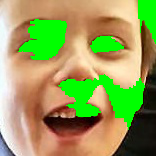

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from skimage.segmentation import mark_boundaries
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from PIL import Image
from pathlib import Path
from IPython.display import display
from lime.lime_image import LimeImageExplainer

def show_image(image):
    # Display the image inline
    display(Image.fromarray(image))


# Provide the path to your image file
image_path = "/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0579.jpg"

# Check if the file exists
if Path(image_path).is_file():
    model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
    target_size = (224, 224)

    # Load the pre-trained VGG16 model with top layers included
    base_model = VGG16(weights='imagenet', include_top=True)

    # Take the output of the base model up to the last convolutional layer
    x = base_model.get_layer('block5_pool').output

    # Add a new dense layer for output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create a new model that takes the input of VGG16 and outputs the desired layer
    model = Model(inputs=base_model.input, outputs=predictions)

    # Process the input image
    img = np.array(Image.open(image_path).resize(target_size))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    img = preprocess_input(img)  # Preprocess the image

    # Preprocess the image for the explainer by dividing pixel values by 255
    img_scaled = img / 255.0

    # Predict ASD probability using the full VGG16 model
    prediction = model.predict(img)[0][0]  # Access the first element for ASD probability

    rounded_prediction = round(prediction, 2)
    print(f"Predicted probability: {rounded_prediction:.2f}")

    if rounded_prediction > 0.5:
        print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

        explainer = LimeImageExplainer()

        # Generate an explanation for the prediction using the explainer object
        explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0, num_samples=10000, random_seed=42)

        # Visualize the explanation using matplotlib
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

        # Resize the explanation mask to match the original image dimensions
        mask = cv2.resize(mask, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)

        # Convert the mask to the original image mode
        original_image = Image.open(image_path)
        #original_image = original_image.convert("L")  # Convert the original image to grayscale
        original_width, original_height = original_image.size
        original_mode = original_image.mode

        # Overlay the explanation mask on the original image
        mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
        original_image = np.array(original_image)
        original_image[mask > 0.5] = (0, 255, 0)



        # Display the original image with the explanation mask
        display(Image.fromarray(original_image))
        # show_image(original_image)

    else:
        print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")
else:
    print("Error: Image file not found.")

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from skimage.segmentation import mark_boundaries
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from PIL import Image
from pathlib import Path
from IPython.display import display
from lime.lime_image import LimeImageExplainer

def show_image(image):
    # Display the image inline
    display(Image.fromarray(image))


# Provide the path to your image file
image_path = "/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0579.jpg"

# Check if the file exists
if Path(image_path).is_file():
    model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
    target_size = (224, 224)

    # Load the pre-trained VGG16 model with top layers included
    base_model = VGG16(weights='imagenet', include_top=True)

    # Take the output of the base model up to the last convolutional layer
    x = base_model.get_layer('block5_pool').output

    # Add a new dense layer for output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create a new model that takes the input of VGG16 and outputs the desired layer
    model = Model(inputs=base_model.input, outputs=predictions)

    # Process the input image
    img = np.array(Image.open(image_path).resize(target_size))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    img = preprocess_input(img)  # Preprocess the image

    # Preprocess the image for the explainer by dividing pixel values by 255
    img_scaled = img / 255.0

    print("Model.predict: ", type(model.predict))
    x2 = model.predict
    print("x2 :", x2)
    # Predict ASD probability using the full VGG16 model
    prediction = model.predict(img)[0][0]  # Access the first element for ASD probability

    rounded_prediction = round(prediction, 2)
    print(f"Predicted probability: {rounded_prediction:.2f}")

    if rounded_prediction > 0.5:
        print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
        # 
        # explainer = LimeImageExplainer()
        # 
        # # Generate an explanation for the prediction using the explainer object
        # explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0, num_samples=10000, random_seed=42)
        # 
        # # Visualize the explanation using matplotlib
        # temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
        # 
        # # Resize the explanation mask to match the original image dimensions
        # mask = cv2.resize(mask, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)
        # 
        # # Convert the mask to the original image mode
        # original_image = Image.open(image_path)
        # #original_image = original_image.convert("L")  # Convert the original image to grayscale
        # original_width, original_height = original_image.size
        # original_mode = original_image.mode
        # 
        # # Overlay the explanation mask on the original image
        # mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
        # original_image = np.array(original_image)
        # original_image[mask > 0.5] = (0, 255, 0)
        # 
        # 
        # 
        # # Display the original image with the explanation mask
        # display(Image.fromarray(original_image))
        # # show_image(original_image)

    else:
        print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")
else:
    print("Error: Image file not found.")

Model.predict:  <class 'method'>
x2 : <bound method Model.predict of <keras.engine.functional.Functional object at 0x285cd1a00>>
1/1 [==============================] - 0s 211ms/step
Predicted probability: 0.22
Predicted non-ASD with probability: 0.78


1/1 [==============================] - 0s 238ms/step
Predicted probability: 0.64
Predicted ASD with probability: 0.64


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


/var/folders/rl/rrwm4k2j0jl36rstbnx1jwfr0000gn/T/ipykernel_5498/2971085014.py:81: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (mask > 0.5).astype(np.bool)


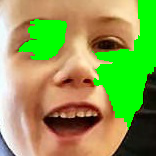

In [19]:
#   import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from skimage.segmentation import mark_boundaries
# from keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# from PIL import Image
# from pathlib import Path
# from IPython.display import display
# from lime.lime_image import LimeImageExplainer
# 
# def show_image(image):
#     # Display the image inline
#     display(Image.fromarray(image))
# 
# 
# # Provide the path to your image file
# image_path = "/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0579.jpg"
# 
# # Check if the file exists
# if Path(image_path).is_file():
#     model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
#     target_size = (224, 224)
# 
#     # Load the pre-trained VGG16 model with top layers included
#     base_model = VGG16(weights='imagenet', include_top=True)
# 
#     # Take the output of the base model up to the last convolutional layer
#     x = base_model.get_layer('block5_pool').output
# 
#     # Add a new dense layer for output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation='relu')(x)
#     predictions = Dense(1, activation='sigmoid')(x)
# 
#     # Create a new model that takes the input of VGG16 and outputs the desired layer
#     model = Model(inputs=base_model.input, outputs=predictions)
# 
#     # Process the input image
#     img = np.array(Image.open(image_path).resize(target_size))
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR
#     img = np.expand_dims(img, axis=0)  # Add a batch dimension
#     img = preprocess_input(img)  # Preprocess the image
# 
#     # Preprocess the image for the explainer by dividing pixel values by 255
#     img_scaled = img / 255.0
# 
#     # Predict ASD probability using the full VGG16 model
#     prediction = model.predict(img)[0][0]  # Access the first element for ASD probability
# 
#     rounded_prediction = round(prediction, 2)
#     print(f"Predicted probability: {rounded_prediction:.2f}")
# 
#     if rounded_prediction > 0.5:
#         print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
# 
#         explainer = LimeImageExplainer()
# 
#         # Generate an explanation for the prediction using the explainer object
#         explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0, num_samples=10000, random_seed=42)
# 
#         # Visualize the explanation using matplotlib
#         temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
# 
#         # Resize the explanation mask to match the original image dimensions
#         mask = cv2.resize(mask, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)
# 
#         # Convert the mask to the original image mode
#         original_image = Image.open(image_path)
#         #original_image = original_image.convert("L")  # Convert the original image to grayscale
#         original_width, original_height = original_image.size
#         original_mode = original_image.mode
# 
#         # Overlay the explanation mask on the original image
#         mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
# 
#         # Convert the mask to a boolean array
#         mask = (mask > 0.5).astype(np.bool)
# 
#         # Create a new image array with the same dimensions as the original image
#         new_image = np.zeros_like(original_image)
# 
#         # Overlay the explanation mask on the original image
#         new_image[mask] = (0, 255, 0)
# 
#         # Combine the original image and the explanation mask
#         combined_image = np.where(mask[..., None], new_image, original_image)
# 
#         # Display the combined image
#         display(Image.fromarray(combined_image))
# 
#     else:
#         print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")
# else:
#     print("Error: Image file not found.")

1/1 [==============================] - 0s 64ms/step


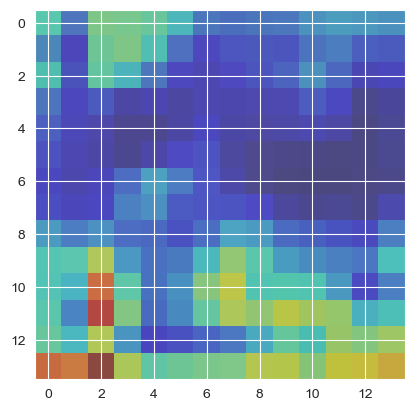

In [13]:
# import cv2
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.models import Model, load_model
# import tensorflow as tf
# 
# # Define Grad-CAM function
# # Define Grad-CAM function
# def generate_grad_cam(model, img_array, layer_name):
#     # Create a model that maps the input image to the desired layer's output
#     grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))
# 
#     # Compute the gradient of the predicted class with respect to the output feature map of the given layer
#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         predicted_class_output = preds[:, 0]  # ASD class index assuming ASD class is the first one
# 
#     grads = tape.gradient(predicted_class_output, last_conv_layer_output)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     last_conv_layer_output = last_conv_layer_output[0]
# 
#     # Compute the heatmap
#     heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
#     heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap
#     heatmap /= np.max(heatmap)  # Normalize
# 
#     return heatmap
# 
# # Define paths
# input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0486.jpg'  # Replace with your image path
# model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
# target_size = (224, 224)
# 
# # Load the pre-trained VGG16 model with top layers included
# base_model = VGG16(weights='imagenet', include_top=True)
# 
# # Create a new model that takes the input of VGG16 and outputs the desired layer/
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)
# 
# # Process the input image
# img = cv2.imread(input_image_path)
# img_original = img.copy()  # Save a copy for visualization later
# img = cv2.resize(img, target_size)
# img_for_model = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))
# 
# # Extract features using the full VGG16 model
# features = model.predict(img_for_model)  # Use the new model
# 
# # Reshape features to match the expected input shape of trained_model
# features_reshaped = np.reshape(features, (features.shape[0], 14, 14, 512))  # Reshape to (None, 14, 14, 512)
# 
# # Load the trained model
# trained_model = load_model(model_path)
# 
# # Predict ASD probability using the trained model and extracted features
# prediction = trained_model.predict(features_reshaped)
# 
# # Visualize the Grad-CAM heatmap
# heatmap = generate_grad_cam(model, img_for_model, 'block5_conv3')
# plt.imshow(img_original)
# plt.imshow(heatmap, alpha=0.5, cmap='jet')
# plt.show()

1/1 [==============================] - 0s 52ms/step
prediction:  1.0
prediction: 1.00000
Predicted probability: 1.00
Predicted ASD with probability: 1.00


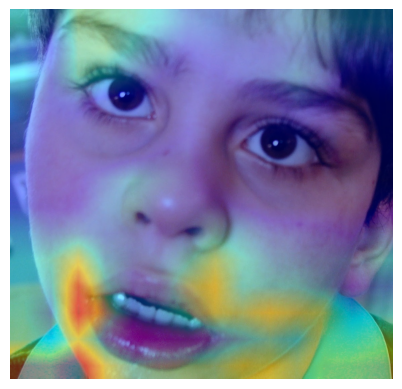

In [14]:
import cv2
import os
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, load_model

# Define Grad-CAM function
def generate_grad_cam(model, img_array, layer_name):
    # Create a model that maps the input image to the desired layer's output
    grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))

    # Compute the gradient of the predicted class with respect to the output feature map of the given layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        predicted_class_output = preds[:, 0]  # ASD class index assuming ASD class is the first one

    grads = tape.gradient(predicted_class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    # Compute the heatmap
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

# Define paths
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0486.jpg'  # Replace with your image path
# input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/test.jpeg'  # Replace with your image path
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
target_size = (224, 224)

# Load the pre-trained VGG16 model with top layers included
base_model = VGG16(weights='imagenet', include_top=True)

# Create a new model that takes the input of VGG16 and outputs the desired layer/
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)

# Process the input image
img = cv2.imread(input_image_path)
img_original = img.copy()
img = cv2.resize(img, target_size)
img = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))

# Extract features using the full VGG16 model
features = model.predict(img)  # Use the new model
# Use base_model directly for feature extraction
# features = base_model.predict(img)

# Reshape features to match the expected input shape of trained_model
features_reshaped = np.reshape(features, (features.shape[0], 14, 14, 512))  # Reshape to (None, 14, 14, 512)

# Load the trained model
trained_model = load_model(model_path)

# Predict ASD probability using the trained model and extracted features
prediction = trained_model.predict(features_reshaped)[0][0]  # Access the first element for ASD probability
print("prediction: ", prediction)
print("prediction: {:.5f}".format(prediction))

# Interpret the prediction
rounded_prediction = round(prediction, 2)
print(f"Predicted probability: {rounded_prediction:.2f}")

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

    # Visualize the Grad-CAM heatmap
    heatmap = generate_grad_cam(model, img_for_model, 'block5_conv3')

    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))

    # Apply colormap for better visualization
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)

    # Display the superimposed image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")

1/1 [==============================] - 0s 110ms/step
Predicted probability: 0.81
Predicted ASD with probability: 0.81


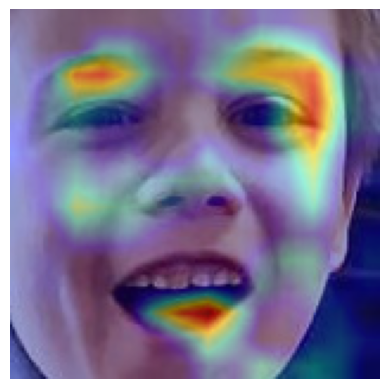

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

from sklearn.preprocessing import MinMaxScaler
from skimage.segmentation import mark_boundaries
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from PIL import Image
from pathlib import Path
from IPython.display import display
import tensorflow as tf
from lime.lime_image import LimeImageExplainer

# Define Grad-CAM function
def generate_grad_cam(model, img_array, layer_name):
    # Create a model that maps the input image to the desired layer's output
    grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))

    # Compute the gradient of the predicted class with respect to the output feature map of the given layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        predicted_class_output = preds[:, 0]  # ASD class index assuming ASD class is the first one

    grads = tape.gradient(predicted_class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    # Compute the heatmap
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

def show_image(image):
    # Display the image inline
    display(Image.fromarray(image))

# Provide the path to your image file
input_image_path = "/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0579.jpg"

# Check if the file exists
if Path(input_image_path).is_file():
    model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
    target_size = (224, 224)

    # Load the pre-trained VGG16 model with top layers included
    base_model = VGG16(weights='imagenet', include_top=True)

    # Take the output of the base model up to the last convolutional layer
    x = base_model.get_layer('block5_pool').output

    # Add a new dense layer for output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create a new model that takes the input of VGG16 and outputs the desired layer
    model = Model(inputs=base_model.input, outputs=predictions)

    # Process the input image
    img = cv2.imread(input_image_path)
    img_original = img.copy()  # Save a copy for visualization later
    img = cv2.resize(img, target_size)
    img_for_model = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))

    # Preprocess the image for the explainer by dividing pixel values by 255
    img_scaled = img / 255.0

    prediction = model.predict(img_for_model)  # Use the new model
    # Predict ASD probability using the full VGG16 model
    # prediction = model.predict(img)[0][0]  # Access the first element for ASD probability

    prediction = model.predict(img_for_model)  # Use the new model
    rounded_prediction = prediction[0][0]  # Access the first element for ASD probability
    
    # Format the scalar value
    print(f"Predicted probability: {rounded_prediction:.2f}")
    
    if rounded_prediction > 0.5:
        print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
    
        # Visualize the Grad-CAM heatmap
        heatmap = generate_grad_cam(model, img_for_model, 'block5_conv3')
    
        # Resize heatmap to match the size of the original image
        heatmap = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))
    
        # Apply colormap for better visualization
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
        # Superimpose the heatmap on the original image
        superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)
    
        # Display the superimposed image
        plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    
    else:
        print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")
else:
    print("Error: Image file not found.")


1/1 [==============================] - 0s 76ms/step
Prediction: 1.00000
Predicted ASD with probability: 1.00


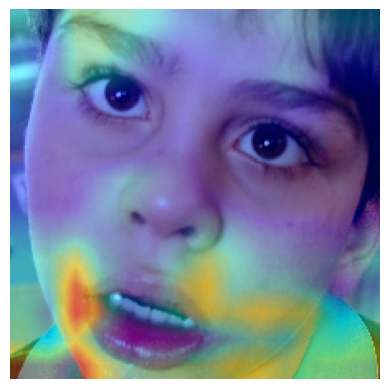

In [9]:
# import cv2
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.models import Model, load_model
# import tensorflow as tf
# 
# # Define Grad-CAM function
# def generate_grad_cam(model, img_array, layer_name):
#     # Create a model that maps the input image to the desired layer's output
#     grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))
# 
#     # Compute the gradient of the predicted class with respect to the output feature map of the given layer
#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         predicted_class_output = preds[:, 0]  # ASD class index assuming ASD class is the first one
# 
#     grads = tape.gradient(predicted_class_output, last_conv_layer_output)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     last_conv_layer_output = last_conv_layer_output[0]
# 
#     # Compute the heatmap
#     heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
#     heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap
#     heatmap /= np.max(heatmap)  # Normalize
# 
#     return heatmap
# 
# # Define paths
# input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0486.jpg'  # Replace with your image path
# model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
# target_size = (224, 224)
# 
# # Load the pre-trained VGG16 model with top layers included
# base_model = VGG16(weights='imagenet', include_top=True)
# 
# # Create a new model that takes the input of VGG16 and outputs the desired layer/
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)
# 
# # Process the input image
# img_original = cv2.imread(input_image_path)
# img_original = cv2.resize(img_original, target_size)
# img_for_model = preprocess_input(np.expand_dims(img_original, axis=0))
# 
# # Extract features using the full VGG16 model
# features = model.predict(img_for_model)  # Use the new model
# 
# # Reshape features to match the expected input shape of trained_model
# features_reshaped = np.reshape(features, (features.shape[0], 14, 14, 512))  # Reshape to (None, 14, 14, 512)
# 
# # Load the trained model
# trained_model = load_model(model_path)
# 
# # Predict ASD probability using the trained model and extracted features
# prediction = trained_model.predict(features_reshaped)[0][0]  # Access the first element for ASD probability
# 
# # Interpret the prediction
# rounded_prediction = round(prediction, 2)
# print("Prediction: {:.5f}".format(prediction))
# 
# if rounded_prediction > 0.5:
#     print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
# 
#     # Visualize the Grad-CAM heatmap
#     heatmap = generate_grad_cam(model, img_for_model, 'block5_conv3')
# 
#     # Resize heatmap to match the size of the original image
#     heatmap = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))
# 
#     # Apply colormap for better visualization
#     heatmap = np.uint8(255 * heatmap)
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 
#     # Superimpose the heatmap on the original image
#     superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)
# 
#     # Display the superimposed image
#     plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.show()
# 
# else:
#     print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")


1/1 [==============================] - 0s 278ms/step
Predicted probability: 1.00
Predicted ASD with probability: 1.00


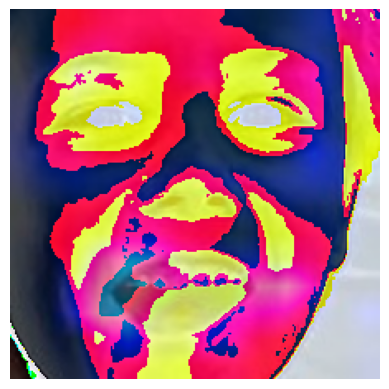

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from PIL import Image
from pathlib import Path

# Define Grad-CAM function
def generate_grad_cam(model, img_array, layer_name):
    # Create a model that maps the input image to the desired layer's output
    grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))

    # Compute the gradient of the predicted class with respect to the output feature map of the given layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        predicted_class_output = preds[:, 0]  # ASD class index assuming ASD class is the first one

    grads = tape.gradient(predicted_class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    # Compute the heatmap
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap
    heatmap /= tf.reduce_max(heatmap)  # Normalize

    return heatmap.numpy()

# Provide the path to your image file
image_path = "/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0579.jpg"

# Check if the file exists
if Path(image_path).is_file():
    model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
    target_size = (224, 224)

    # Load the pre-trained VGG16 model with top layers included
    base_model = VGG16(weights='imagenet', include_top=True)

    # Take the output of the base model up to the last convolutional layer
    x = base_model.get_layer('block5_pool').output

    # Add a new dense layer for output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create a new model that takes the input of VGG16 and outputs the desired layer
    model = Model(inputs=base_model.input, outputs=predictions)

    # Process the input image
    img = np.array(Image.open(image_path).resize(target_size))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    img = preprocess_input(img)  # Preprocess the image

    # Preprocess the image for the explainer by dividing pixel values by 255
    img_scaled = img / 255.0

    # Predict ASD probability using the full VGG16 model
    prediction = model.predict(img)[0][0]  # Access the first element for ASD probability

    rounded_prediction = round(prediction, 2)
    print(f"Predicted probability: {rounded_prediction:.2f}")

    if rounded_prediction > 0.5:
        print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

        # Visualize the Grad-CAM heatmap
        heatmap = generate_grad_cam(model, img, 'block5_conv3')

        # Resize heatmap to match the size of the original image
        heatmap = cv2.resize(heatmap, (target_size[0], target_size[1]))

        # Normalize heatmap to range [0, 255]
        heatmap = np.uint8(255 * heatmap)

        # Apply colormap for better visualization
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)


# Convert heatmap to BGR format
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)

        # Blend heatmap with the original image
        superimposed_img = cv2.addWeighted(img[0].astype(np.float32), 0.5, heatmap.astype(np.float32), 0.5, 0).astype(np.uint8)


# Display the superimposed image
        plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    else:
        print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")
else:
    print("Error: Image file not found.")


1/1 [==============================] - 0s 109ms/step
Predicted probability: 0.97
Predicted ASD with probability: 0.97


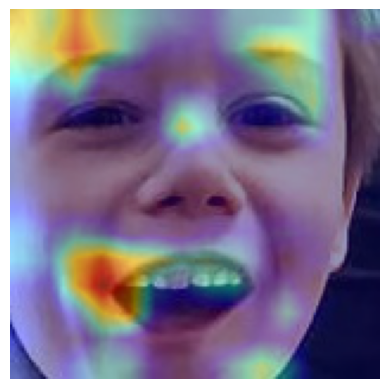

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

from sklearn.preprocessing import MinMaxScaler
from skimage.segmentation import mark_boundaries
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from PIL import Image
from pathlib import Path
from IPython.display import display
import tensorflow as tf
from lime.lime_image import LimeImageExplainer

# Define Grad-CAM function
def generate_grad_cam(model, img_array, layer_name):
    # Create a model that maps the input image to the desired layer's output
    grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))

    # Compute the gradient of the predicted class with respect to the output feature map of the given layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        predicted_class_output = preds[:, 0]  # ASD class index assuming ASD class is the first one

    grads = tape.gradient(predicted_class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    # Compute the heatmap
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

def show_image(image):
    # Display the image inline
    display(Image.fromarray(image))

# Provide the path to your image file
input_image_path = "/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0579.jpg"

# Check if the file exists
if Path(input_image_path).is_file():
    model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
    target_size = (224, 224)

    # Load the pre-trained VGG16 model with top layers included
    base_model = VGG16(weights='imagenet', include_top=True)

    # Take the output of the base model up to the last convolutional layer
    x = base_model.get_layer('block5_pool').output

    # Add a new dense layer for output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create a new model that takes the input of VGG16 and outputs the desired layer
    model = Model(inputs=base_model.input, outputs=predictions)

    # Process the input image
    img = cv2.imread(input_image_path)
    img_original = img.copy()  # Save a copy for visualization later
    img = cv2.resize(img, target_size)
    img_for_model = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))

    # Preprocess the image for the explainer by dividing pixel values by 255
    img_scaled = img / 255.0

    # prediction = model.predict(img_for_model)  # Use the new model
    # Predict ASD probability using the full VGG16 model
    # prediction = model.predict(img)[0][0]  # Access the first element for ASD probability

    prediction = model.predict(img_for_model)  # Use the new model
    rounded_prediction = prediction[0][0]  # Access the first element for ASD probability

    # Format the scalar value
    print(f"Predicted probability: {rounded_prediction:.2f}")

    if rounded_prediction > 0.5:
        print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

        # Visualize the Grad-CAM heatmap
        heatmap = generate_grad_cam(model, img_for_model, 'block5_conv3')

        # Resize heatmap to match the size of the original image
        heatmap = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))

        # Apply colormap for better visualization
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Superimpose the heatmap on the original image
        superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)

        # Display the superimposed image
        plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    else:
        print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")
else:
    print("Error: Image file not found.")
